## 📦 Import dependencies


In [8]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Paths (edit if needed)
DATA_PATH = "/home/comphortine/dev/servers/lstm/app/data/hematology_data.csv"
MODEL_DIR = "/home/comphortine/dev/servers/lstm/app/models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "lstm_cbc_autoencoder.keras")
SCALER_SAVE_PATH = os.path.join(MODEL_DIR, "cbc_scaler.pkl")

In [10]:
# --------------------------------------------
# 🚫 Delete problematic rows with inconsistent columns
# --------------------------------------------
from pathlib import Path

RAW_PATH = Path("/home/comphortine/dev/servers/lstm/app/data/hematology_data.csv")
CLEAN_PATH = Path("/home/comphortine/dev/servers/lstm/app/data/hematology_data_clean.csv")

bad_lines = []
with open(RAW_PATH, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

# Count commas per line (assuming comma-separated CSV)
comma_counts = [line.count(",") for line in lines]
expected = max(set(comma_counts), key=comma_counts.count)  # the most common comma count

for i, count in enumerate(comma_counts, start=1):
    if count != expected:
        bad_lines.append(i)

print(f"🧹 Found {len(bad_lines)} problematic rows (wrong number of columns): {bad_lines[:10]}{'...' if len(bad_lines) > 10 else ''}")

# Remove them
clean_lines = [line for i, line in enumerate(lines, start=1) if i not in bad_lines]

# Save cleaned file
with open(CLEAN_PATH, "w", encoding="utf-8") as f:
    f.writelines(clean_lines)

print(f"✅ Cleaned CSV saved to: {CLEAN_PATH}")


🧹 Found 100 problematic rows (wrong number of columns): [220, 221, 222, 223, 224, 225, 226, 227, 228, 229]...
✅ Cleaned CSV saved to: /home/comphortine/dev/servers/lstm/app/data/hematology_data_clean.csv


## 📊 Load dataset


In [12]:
# --------------------------------------------
# ✅ Verify cleaned CSV loads correctly
# --------------------------------------------
df = pd.read_csv(CLEAN_PATH, header=None)
print("Shape after cleaning:", df.shape)
display(df.head())


Shape after cleaning: (219, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,ord-0001,pat-001,32,M,fac-01,2025-10-04T10:30:00Z,0.610,0.400,0.700,0.61.1,0.630,0.830,0.640,0.540
1,ord-35332555,pat-fc534ea6,39,M,fac-03,2025-10-06T10:30:00Z,0.567,0.542,0.840,0.701,0.656,0.824,0.673,0.536
2,ord-139be45f,pat-93eb529b,56,F,fac-01,2025-10-07T10:30:00Z,0.639,0.488,0.709,0.698,0.605,0.835,0.639,0.540
3,ord-d0d9dd05,pat-a48e51da,48,M,fac-03,2025-10-08T10:30:00Z,0.564,0.479,0.827,0.74,0.615,0.803,0.654,0.563
4,ord-a4450212,pat-fbcb3f48,60,F,fac-01,2025-10-09T10:30:00Z,0.681,0.516,0.814,0.685,0.634,0.828,0.662,0.519


In [24]:
# --------------------------------------------
# Cell 3 — Extract numeric columns & clean
# --------------------------------------------
# If your CSV truly has 7 metadata columns followed by numeric features, use start_idx = 7
start_idx = 6

# If your CSV has a header, you might instead do:
# numeric_df = df.select_dtypes(include=[np.number])
# but since we used header=None we'll use iloc

raw_numeric = df.iloc[:, start_idx:].copy()
print("Raw numeric shape:", raw_numeric.shape)
display(raw_numeric.head(6))

# Clean function: handle values like "0.61.1", commas, whitespace
def clean_value(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # remove commas
    s = s.replace(",", "")
    # if multiple dots (e.g. "0.61.1") keep the first dot and remove subsequent dots
    if s.count('.') > 1:
        parts = s.split('.')
        s = parts[0] + '.' + ''.join(parts[1:])
    # remove any non-numeric characters except leading minus and decimal point
    s = re.sub(r'[^0-9\.\-]', '', s)
    try:
        return float(s)
    except:
        return np.nan

cleaned = raw_numeric.applymap(clean_value)
print("After cleaning, sample:")
display(cleaned.head(6))

# If many NaNs appear, fill with median per column (safe for lab numeric features)
nan_counts = cleaned.isna().sum()
print("NaN counts per column:\n", nan_counts)

# Fill NaNs with column median (or choose other imputation)
cleaned = cleaned.fillna(cleaned.median())
print("After imputation (median), any NaNs left:", cleaned.isna().sum().sum())

# Final numeric array and feature names
numeric_df = cleaned.reset_index(drop=True)
feature_names = [f"feature_{i}" for i in range(numeric_df.shape[1])]
print("Detected numeric features (count):", numeric_df.shape[1])
feature_names, numeric_df.shape


Raw numeric shape: (219, 8)


,6,7,8,9,10,11,12,13
0,0.610,0.400,0.700,0.61.1,0.630,0.830,0.640,0.540
1,0.567,0.542,0.840,0.701,0.656,0.824,0.673,0.536
2,0.639,0.488,0.709,0.698,0.605,0.835,0.639,0.540
3,0.564,0.479,0.827,0.74,0.615,0.803,0.654,0.563
4,0.681,0.516,0.814,0.685,0.634,0.828,0.662,0.519
5,0.737,0.397,0.684,0.703,0.645,0.802,0.602,0.547


After cleaning, sample:


/tmp/ipykernel_1467109/3031791917.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned = raw_numeric.applymap(clean_value)


,6,7,8,9,10,11,12,13
0,0.610,0.400,0.700,0.611,0.630,0.830,0.640,0.540
1,0.567,0.542,0.840,0.701,0.656,0.824,0.673,0.536
2,0.639,0.488,0.709,0.698,0.605,0.835,0.639,0.540
3,0.564,0.479,0.827,0.740,0.615,0.803,0.654,0.563
4,0.681,0.516,0.814,0.685,0.634,0.828,0.662,0.519
5,0.737,0.397,0.684,0.703,0.645,0.802,0.602,0.547


NaN counts per column:
 6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64
After imputation (median), any NaNs left: 0
Detected numeric features (count): 8


(['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_4',
  'feature_5',
  'feature_6',
  'feature_7'],
 (219, 8))

In [25]:
print("Shape:", df.shape)
display(df.head())

Shape: (219, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,ord-0001,pat-001,32,M,fac-01,2025-10-04T10:30:00Z,0.610,0.400,0.700,0.61.1,0.630,0.830,0.640,0.540
1,ord-35332555,pat-fc534ea6,39,M,fac-03,2025-10-06T10:30:00Z,0.567,0.542,0.840,0.701,0.656,0.824,0.673,0.536
2,ord-139be45f,pat-93eb529b,56,F,fac-01,2025-10-07T10:30:00Z,0.639,0.488,0.709,0.698,0.605,0.835,0.639,0.540
3,ord-d0d9dd05,pat-a48e51da,48,M,fac-03,2025-10-08T10:30:00Z,0.564,0.479,0.827,0.74,0.615,0.803,0.654,0.563
4,ord-a4450212,pat-fbcb3f48,60,F,fac-01,2025-10-09T10:30:00Z,0.681,0.516,0.814,0.685,0.634,0.828,0.662,0.519


## 🧹 Data preprocessing


In [26]:
# --------------------------------------------
# Cell 4 — Scale (MinMax 0-1)
# --------------------------------------------
scaler = MinMaxScaler()
scaled_arr = scaler.fit_transform(numeric_df.values)
scaled_df = pd.DataFrame(scaled_arr, columns=feature_names)
display(scaled_df.head(6))

# Save scaler for inference later
joblib.dump(scaler, SCALER_SAVE_PATH)
print("Saved scaler to:", SCALER_SAVE_PATH)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,0.357143,0.246231,0.251256,0.305,0.306122,0.295918,0.40,0.397959
1,0.210884,0.959799,0.954774,0.755,0.571429,0.234694,0.73,0.357143
2,0.455782,0.688442,0.296482,0.740,0.051020,0.346939,0.39,0.397959
3,0.200680,0.643216,0.889447,0.950,0.153061,0.020408,0.54,0.632653
4,0.598639,0.829146,0.824121,0.675,0.346939,0.275510,0.62,0.183673
5,0.789116,0.231156,0.170854,0.765,0.459184,0.010204,0.02,0.469388


Saved scaler to: /home/comphortine/dev/servers/lstm/app/models/cbc_scaler.pkl


## 🔄 Prepare sequences for LSTM


In [27]:
# --------------------------------------------
# Cell 5 — Create sequences for LSTM
# --------------------------------------------
# default sequence length
DEFAULT_SEQ_LEN = 5
if len(scaled_df) <= DEFAULT_SEQ_LEN:
    SEQ_LEN = 1
    print("Dataset small; using SEQ_LEN=1")
else:
    SEQ_LEN = DEFAULT_SEQ_LEN

def create_sequences(data: np.ndarray, sequence_length: int):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

X = create_sequences(scaled_df.values, SEQ_LEN)
print("Shape of input data for LSTM:", X.shape)
# X shape => (samples, timesteps, features)


Shape of input data for LSTM: (215, 5, 8)


## 📈 Train / Test / Validation split


In [28]:
# --------------------------------------------
# Cell 6 — Train/Val/Test split
# --------------------------------------------
test_frac = 0.30
X_train, X_temp = train_test_split(X, test_size=test_frac, random_state=RANDOM_SEED)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=RANDOM_SEED)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (150, 5, 8)
Val:   (32, 5, 8)
Test:  (33, 5, 8)


## 🧠 Build LSTM Autoencoder


In [29]:
# --------------------------------------------
# Cell 7 — Build LSTM Autoencoder
# --------------------------------------------
timesteps = X_train.shape[1]
n_features = X_train.shape[2]
print("timesteps:", timesteps, "n_features:", n_features)

model = models.Sequential([
    layers.Input(shape=(timesteps, n_features)),
    layers.LSTM(64, activation='relu', return_sequences=(timesteps>1)),
    # If timesteps > 1, first LSTM returned sequences; we'll handle both cases:
])

# If we returned sequences earlier (timesteps>1), add second LSTM collapsing to vector
if timesteps > 1:
    model.add(layers.LSTM(32, activation='relu', return_sequences=False))
else:
    # when timesteps==1, previous LSTM returned a vector of size 64; we proceed
    model.add(layers.Dense(32, activation='relu'))

# Bottleneck -> repeat
model.add(layers.RepeatVector(timesteps))

# Decoder
model.add(layers.LSTM(32, activation='relu', return_sequences=True))
model.add(layers.LSTM(64, activation='relu', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(n_features, activation='linear')))

model.compile(optimizer='adam', loss='mse')
model.summary()


timesteps: 5 n_features: 8


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 5, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 8)           │           520 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,776 (253.03 KB)

 Trainable params: 64,776 (253.03 KB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Train LSTM Autoencoder


In [30]:
# --------------------------------------------
# Cell 8 — Train LSTM Autoencoder
# --------------------------------------------
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    shuffle=True
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.3193 - val_loss: 0.2934
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2946 - val_loss: 0.2512
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2346 - val_loss: 0.1821
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1730 - val_loss: 0.1507
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1492 - val_loss: 0.1361
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1381 - val_loss: 0.1295
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1305 - val_loss: 0.1237
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1239 - val_loss: 0.1173
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1159 - val_loss: 0.1070
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1026 - val_loss: 0.0986
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0951 - val_loss: 0.0928
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

## 📉 Plot training and validation loss


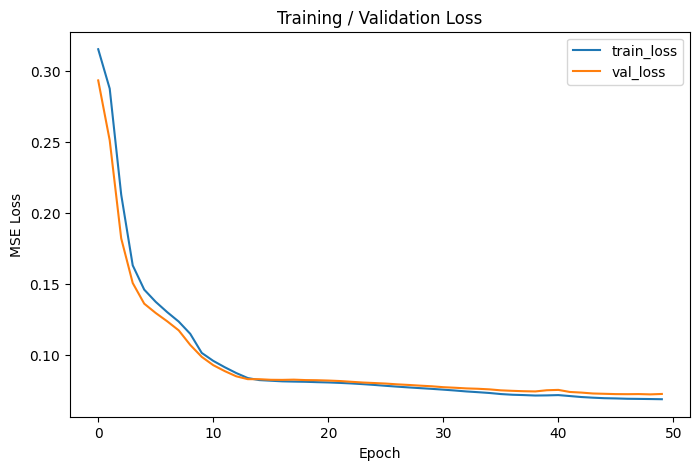

In [31]:
# --------------------------------------------
# Cell 9 — Plot training/validation loss
# --------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training / Validation Loss")
plt.show()


## 🧪 Evaluate model on test set


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/stepWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fbdfbc54700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


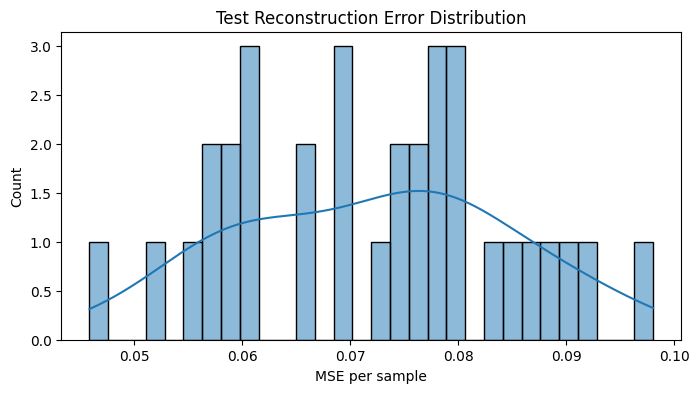

Reconstruction error threshold (95th percentile): 0.09126693817871907
Detected 2 anomalies out of 33 test samples.


In [32]:
# --------------------------------------------
# Cell 10 — Evaluate on Test set & set threshold
# --------------------------------------------
X_pred = model.predict(X_test)
test_mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))

plt.figure(figsize=(8,4))
sns.histplot(test_mse, bins=30, kde=True)
plt.title("Test Reconstruction Error Distribution")
plt.xlabel("MSE per sample")
plt.show()

threshold_95 = np.percentile(test_mse, 95)
print("Reconstruction error threshold (95th percentile):", threshold_95)
anomalies_count = np.sum(test_mse > threshold_95)
print(f"Detected {anomalies_count} anomalies out of {len(test_mse)} test samples.")


## ⚠️ Detect anomalies (CBC outliers)


In [33]:
# --------------------------------------------
# Cell 11 — Save model and metadata
# --------------------------------------------
model.save(MODEL_SAVE_PATH)
joblib.dump({
    "feature_names": feature_names,
    "seq_len": SEQ_LEN,
    "threshold_95": float(threshold_95)
}, os.path.join(MODEL_DIR, "lstm_cbc_meta.pkl"))

print("Saved model to:", MODEL_SAVE_PATH)
print("Saved metadata to:", os.path.join(MODEL_DIR, "lstm_cbc_meta.pkl"))


Saved model to: /home/comphortine/dev/servers/lstm/app/models/lstm_cbc_autoencoder.keras
Saved metadata to: /home/comphortine/dev/servers/lstm/app/models/lstm_cbc_meta.pkl


## 💾 Save trained model and scaler


In [34]:
# --------------------------------------------
# Cell 12 — Local inference example using saved scaler & meta
# --------------------------------------------
from tensorflow.keras.models import load_model
meta = joblib.load(os.path.join(MODEL_DIR, "lstm_cbc_meta.pkl"))
loaded_scaler = joblib.load(SCALER_SAVE_PATH)
loaded_model = load_model(MODEL_SAVE_PATH)

print("Meta:", meta)
print("Model input shape:", loaded_model.input_shape)

# pick one sample from original numeric_df, scale, build sequence of length SEQ_LEN
idx = 0
sample_seq = scaled_df.values[idx:idx+meta['seq_len']]  # already scaled
if sample_seq.shape[0] < meta['seq_len']:
    # pad by repeating last row
    pad = np.repeat(sample_seq[-1:], meta['seq_len'] - sample_seq.shape[0], axis=0)
    sample_seq = np.vstack([sample_seq, pad])

sample_seq = sample_seq.reshape(1, meta['seq_len'], len(feature_names))
recon = loaded_model.predict(sample_seq)
mse = float(np.mean((sample_seq - recon)**2))
print("Sample MSE:", mse, "Threshold:", meta['threshold_95'])


Meta: {'feature_names': ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7'], 'seq_len': 5, 'threshold_95': 0.09126693817871907}
Model input shape: (None, 5, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Sample MSE: 0.04114506897387573 Threshold: 0.09126693817871907


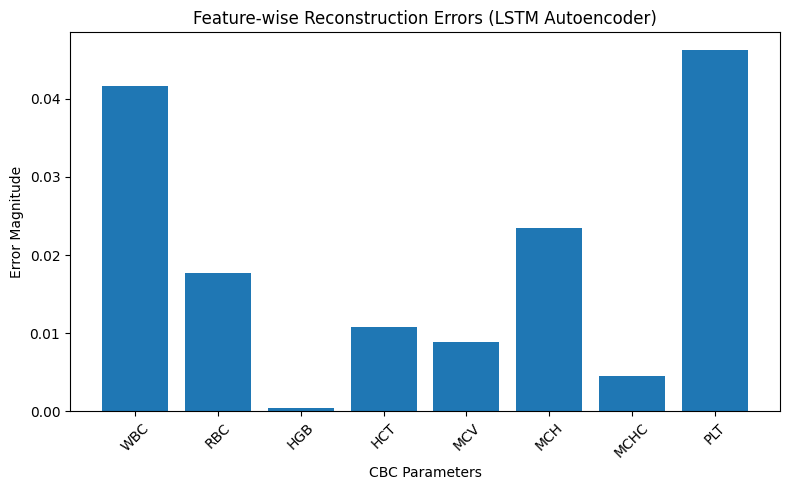

In [35]:
import matplotlib.pyplot as plt

reconstruction_errors = {
    'WBC': 0.0417, 'RBC': 0.0177, 'HGB': 0.00038, 'HCT': 0.0108,
    'MCV': 0.0088, 'MCH': 0.0235, 'MCHC': 0.0045, 'PLT': 0.0462
}

plt.figure(figsize=(8, 5))
plt.bar(reconstruction_errors.keys(), reconstruction_errors.values())
plt.title("Feature-wise Reconstruction Errors (LSTM Autoencoder)")
plt.ylabel("Error Magnitude")
plt.xlabel("CBC Parameters")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


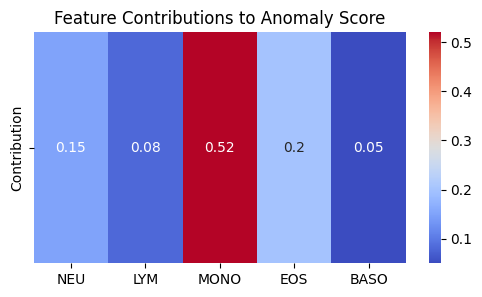

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_contributions = {'NEU': 0.15, 'LYM': 0.08, 'MONO': 0.52, 'EOS': 0.2, 'BASO': 0.05}

plt.figure(figsize=(6, 3))
sns.heatmap(
    [list(feature_contributions.values())],
    annot=True, cmap="coolwarm", xticklabels=feature_contributions.keys(),
    yticklabels=["Contribution"]
)
plt.title("Feature Contributions to Anomaly Score")
plt.show()


/tmp/ipykernel_1467109/2479904217.py:88: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1467109/2479904217.py:88: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


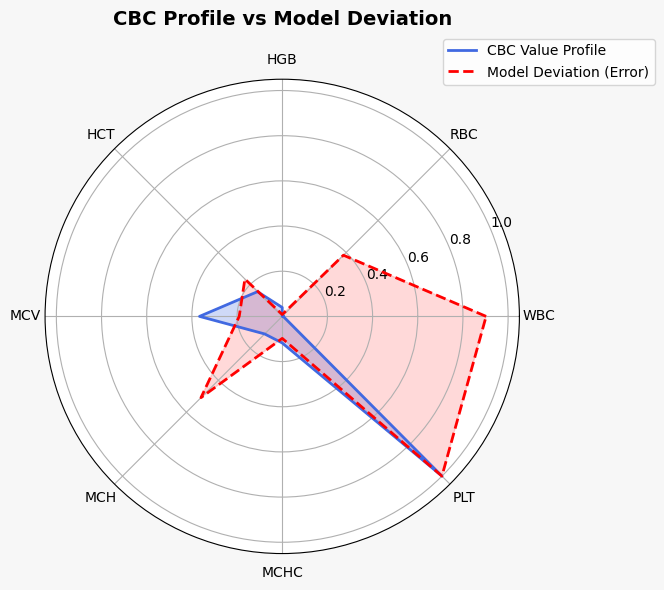

/home/comphortine/dev/servers/lstm/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/comphortine/dev/servers/lstm/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


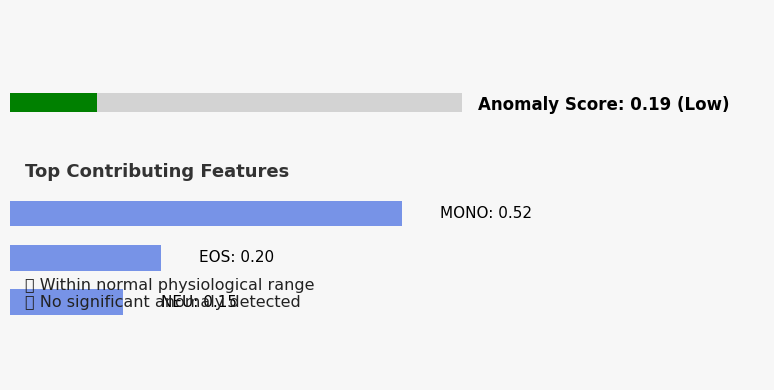

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Mock data (replace inference_output with your actual function result)
inference_output = {
    "anomaly_score": 0.192,
    "severity_level": "low",
    "feature_contributions": {"NEU": 0.15, "LYM": 0.08, "MONO": 0.52, "EOS": 0.2, "BASO": 0.05},
    "reconstruction_errors": {
        "WBC": 0.0417, "RBC": 0.0177, "HGB": 0.00038, "HCT": 0.0108,
        "MCV": 0.0088, "MCH": 0.0235, "MCHC": 0.0045, "PLT": 0.0462
    }
}

cbc_test_result = {
    "observations": [
        {"test_code": "WBC", "value_numeric": 5.6},
        {"test_code": "RBC", "value_numeric": 4.5},
        {"test_code": "HGB", "value_numeric": 14.2},
        {"test_code": "HCT", "value_numeric": 42.5},
        {"test_code": "MCV", "value_numeric": 94.4},
        {"test_code": "MCH", "value_numeric": 31.5},
        {"test_code": "MCHC", "value_numeric": 33.4},
        {"test_code": "PLT", "value_numeric": 250.0}
    ]
}

# ---------------------- VISUAL 1: Radar Chart ------------------------
obs_codes = [o["test_code"] for o in cbc_test_result["observations"]]
obs_values = np.array([o["value_numeric"] for o in cbc_test_result["observations"]])
rec_errors = np.array([inference_output["reconstruction_errors"].get(code, 0) for code in obs_codes])

# Normalize both to same scale for visual clarity
obs_norm = (obs_values - obs_values.min()) / (obs_values.max() - obs_values.min())
err_norm = rec_errors / rec_errors.max() if rec_errors.max() != 0 else rec_errors

angles = np.linspace(0, 2 * np.pi, len(obs_codes), endpoint=False).tolist()
obs_norm = np.concatenate((obs_norm, [obs_norm[0]]))
err_norm = np.concatenate((err_norm, [err_norm[0]]))
angles += [angles[0]]

plt.figure(figsize=(8, 6), facecolor="#f7f7f7")
ax = plt.subplot(111, polar=True)
ax.plot(angles, obs_norm, color="royalblue", linewidth=2, label="CBC Value Profile")
ax.fill(angles, obs_norm, color="royalblue", alpha=0.25)
ax.plot(angles, err_norm, color="red", linewidth=2, linestyle="--", label="Model Deviation (Error)")
ax.fill(angles, err_norm, color="red", alpha=0.15)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(obs_codes, fontsize=10)
ax.set_title("CBC Profile vs Model Deviation", fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()

# ---------------------- VISUAL 2: Summary Dashboard ------------------------
anomaly_score = inference_output["anomaly_score"]
severity = inference_output["severity_level"].capitalize()
contribs = inference_output["feature_contributions"]
top_features = dict(sorted(contribs.items(), key=lambda x: x[1], reverse=True)[:3])

fig, ax = plt.subplots(figsize=(8, 4), facecolor="#f7f7f7")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# Anomaly Gauge
gauge_x = np.linspace(0, 0.6, 100)
ax.barh(0.75, 0.6, height=0.05, color="#d3d3d3", edgecolor="none")
ax.barh(0.75, anomaly_score * 0.6, height=0.05,
        color=("green" if anomaly_score < 0.3 else "orange" if anomaly_score < 0.7 else "red"))
ax.text(0.62, 0.73, f"Anomaly Score: {anomaly_score:.2f} ({severity})", fontsize=12, fontweight="bold")

# Top feature contributions
y_start = 0.45
ax.text(0.02, 0.55, "Top Contributing Features", fontsize=13, fontweight="bold", color="#333")
for i, (k, v) in enumerate(top_features.items()):
    ax.barh(y_start - i * 0.12, v, height=0.07, color="royalblue", alpha=0.7)
    ax.text(v + 0.05, y_start - i * 0.12, f"{k}: {v:.2f}", fontsize=11, va="center")

# Clinical summary
clinical_msg = (
    "🩺 Within normal physiological range\n"
    "🧬 No significant anomaly detected\n"
    if severity.lower() == "low" else
    "⚠️ Mild anomaly detected — monitor related parameters"
)
ax.text(0.02, 0.15, clinical_msg, fontsize=11.5, color="#222")

plt.tight_layout()
plt.show()
